c:\Users\johnm\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1198])) that is different to the input size (torch.Size([1198, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.3114
Test Loss:  0.10705844312906265


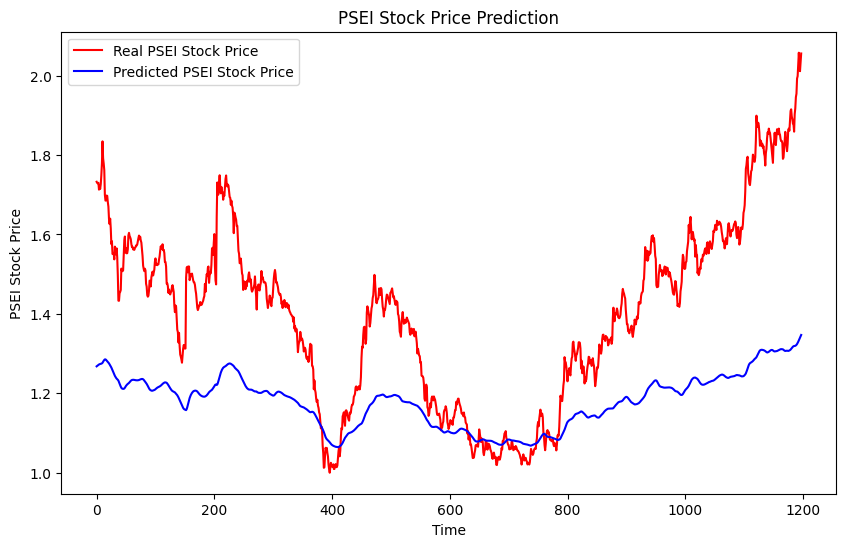

In [2]:
# Testing LSTM in PSEI data using PyTorch
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the dataset
df = pd.read_csv('data/PSEI.csv')

# Getting the training set
training_set = df.iloc[:, 1:2].values
training_set

training_set_scaled = ( training_set / training_set.min() )

# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Part 2 - Building the RNN using Torch
import torch.nn as nn

# Initialising the RNN
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 0.001  
model = RNN(input_size=1, hidden_size=100, num_layers=2, num_classes=1).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    inputs = torch.from_numpy(X_train).float().to(device)
    targets = torch.from_numpy(y_train).float().to(device)

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}' 
               .format(epoch+1, num_epochs, loss.item()))

# Test the model
model.eval()
with torch.no_grad():
    inputs = torch.from_numpy(X_train).float().to(device)
    targets = torch.from_numpy(y_train).float().to(device)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    print("Test Loss: ", loss.item())

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

# Plotting the results
plt.figure(figsize=(10,6))
plt.plot(y_train, color = 'red', label = 'Real PSEI Stock Price')
plt.plot(outputs.cpu().detach().numpy(), color = 'blue', label = 'Predicted PSEI Stock Price')
plt.title('PSEI Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('PSEI Stock Price')
plt.legend()
plt.show()